In [ ]:
# code reference: https://github.com/jatinmandav/Neural-Networks/blob/master/Sentiment-Analysis/fastText/sentiment_analysis_fastext.ipynb
# import libraries
from gensim.models import FastText
import pandas as pd
import time
import numpy as np
import keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from tensorflow import keras
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
# import dataset
df_train =pd.read_csv('/content/drive/MyDrive/Information_Retrieval_Project/Fasttext_CNN/train_data_inference.csv')
df_test =pd.read_csv('/content/drive/MyDrive/Information_Retrieval_Project/Fasttext_CNN/test_data_inference.csv')

In [76]:
df_train.shape

(2834, 14)

In [79]:
df_train['sentiment'].value_counts()

 0.0    1539
 1.0     760
-1.0     535
Name: sentiment, dtype: int64

In [178]:
df_train.head()

,Unnamed: 0,processed_content,sentiment,username,content,date,country,replyCount,retweetCount,likeCount,url,textblob_class,vader_class,inference
0,0,thank you for this huge opportunity to win fol...,1.0,itzeyrnz_21,@chitaglorya__ @BTC_NFT @CryptoZillaVC @Block_...,2021-11-14 03:15:09+00:00,Israel,0,0,0,https://twitter.com/itzeyrnz_21/status/1459721...,1,1,1.0
1,6,i be work this myself great project lot of pot...,1.0,GillBa8scrypto,@yvtweets I'm working this myself...great proj...,2021-12-27 23:59:50+00:00,Argentina,0,0,0,https://twitter.com/GillBa8scrypto/status/1475...,1,1,1.0
2,9,at least 50 bitcoin,1.0,Skywalker01m,At least 50 bitcoins @ZentralratJuden,2021-11-14 18:12:30+00:00,France,1,0,0,https://twitter.com/Skywalker01m/status/145994...,-1,0,0.0
3,14,show me your bank interest bank earn by loudsp...,1.0,rBelgriego,Show me your bank interest 🏦\nEarnings by http...,2021-11-11 13:36:08+00:00,France,2,4,15,https://twitter.com/rBelgriego/status/14587906...,0,1,0.0
4,15,here we be with the fax with max tik tok page ...,0.0,StateyTeam,Here we are with the Fax with Max Tik Tok page...,2021-11-08 02:43:14+00:00,Mexico,1,2,0,https://twitter.com/StateyTeam/status/14575391...,0,0,0.0


In [80]:
df_test.shape

(1149, 14)

In [81]:
df_test['sentiment'].value_counts()

 0    542
 1    388
-1    219
Name: sentiment, dtype: int64

In [83]:
df_test.head()

,Unnamed: 0,processed_content,sentiment,username,content,date,country,replyCount,retweetCount,likeCount,url,textblob_class,vader_class,inference
0,4,all you need to do be keep buy utc and eth and...,1,Shamrock680,@robertakanda @RobertOstler All you need to do...,2021-12-27 23:52:56+00:00,Argentina,0,0,0,https://twitter.com/Shamrock680/status/1475615...,0,0,1.0
1,5,buy bitcoin on the bitstamp exchange this type...,0,BskdTina,Buying Bitcoins on the Bitstamp exchange. This...,2021-12-27 22:30:40+00:00,Argentina,0,0,3,https://twitter.com/BskdTina/status/1475595009...,1,1,0.0
2,12,a quick update on the recent performance of po...,1,PigsterC,A quick update on the recent performance of Pi...,2021-12-26 22:28:22+00:00,Argentina,0,1,1,https://twitter.com/PigsterC/status/1475232043...,1,1,1.0
3,19,utc bounce at 60300 rocket rocket rocket,1,Stockwa60818438,BTC bounce at 60300 🚀🚀🚀,2021-10-29 07:23:35+00:00,Switzerland,0,0,0,https://twitter.com/Stockwa60818438/status/145...,0,0,1.0
4,21,sound like a good recipe to me smiling_face hu...,1,CEOSCRYPTO,Sounds like a good #CryptoEqualsOptions recipe...,2021-12-26 20:05:07+00:00,Argentina,0,0,1,https://twitter.com/CEOSCRYPTO/status/14751959...,1,1,1.0


In [123]:
df1=pd.DataFrame(df_train['processed_content'])
df1['sentiment']= df_train['sentiment']
df2=pd.DataFrame(df_test['processed_content'])
df2['sentiment']= df_test['sentiment']
df3 = df1.append(df2)
df3.head()

,processed_content,sentiment
0,thank you for this huge opportunity to win fol...,1.0
1,i be work this myself great project lot of pot...,1.0
2,at least 50 bitcoin,1.0
3,show me your bank interest bank earn by loudsp...,1.0
4,here we be with the fax with max tik tok page ...,0.0


In [124]:
# declaring constants
vector_size = 100
window = 5

In [119]:
# trianing fats text model
fasttext_model = '/content/drive/MyDrive/Information_Retrieval_Project/Fasttext_CNN/fasttext.model'

print('Generating FastText Vectors ..')

start = time.time()

model = FastText(size=vector_size)
model.build_vocab(df3['processed_content'])
model.train(df3['processed_content'], window=window, min_count=1, workers=4, 
            total_examples=model.corpus_count, epochs=model.epochs)

print('FastText Created in {} seconds.'.format(time.time() - start))

model.save(fasttext_model)
print('FastText Model saved at {}'.format(fasttext_model))

del model

Generating FastText Vectors ..
FastText Created in 1.757413387298584 seconds.
FastText Model saved at /content/drive/MyDrive/Information_Retrieval_Project/Fasttext_CNN/fasttext.model


In [120]:
# load trained model
model = FastText.load(fasttext_model)

In [121]:
# extract word vectors
x_vectors = model.wv
del model

In [122]:
x_vectors

In [125]:
len(df3['sentiment']), len(df3['processed_content'])

(3983, 3983)

In [98]:
# train test split
train_size = int((len(df_train['processed_content'])))
test_size = int((len(df_test['processed_content'])))

max_no_tokens = 100

indexes = set(range(0,train_size + test_size))

x_train = np.zeros((train_size, max_no_tokens, vector_size), dtype=K.floatx())
y_train = np.zeros((train_size, 3), dtype=np.int32)

x_test = np.zeros((test_size, max_no_tokens, vector_size), dtype=K.floatx())
y_test = np.zeros((test_size, 3), dtype=np.int32)

In [100]:
train_size, test_size

(2834, 1149)

In [126]:
tweets = list(df3['processed_content'])
labels = list(df3['sentiment'])

In [127]:
len(labels), len(tweets)

(3983, 3983)

In [128]:
# checking value of a word vector
for t, token in enumerate(tweets[8]):
  print(t, token, x_vectors[token])
  break

0 s [-0.02060172  0.2658589   0.08284557  0.25081208 -0.01369779  0.03255726
 -0.10270236 -0.09966093 -0.09792434  0.0558719   0.01590674 -0.18257432
  0.01860484 -0.061795   -0.0217042  -0.00441985 -0.18196663  0.08945573
  0.08428988 -0.12061337  0.10030702  0.09067033 -0.04683849  0.02830318
  0.03862913 -0.10733231  0.08813316 -0.04945845  0.12508601  0.19624329
 -0.16419488  0.02687796 -0.11140849 -0.03454421 -0.01382594 -0.20924357
  0.16989154 -0.01289965  0.16246623  0.04966501 -0.01680589 -0.03330917
 -0.17004412  0.09627032 -0.00301769  0.04125416 -0.02924835  0.04532868
 -0.04223333 -0.20247473  0.08128985  0.00776491 -0.0496254   0.04577317
  0.03402416  0.07353009  0.04381324  0.11833711 -0.00361559  0.07402693
  0.04477737  0.08693133  0.06425473  0.0295135   0.03334414 -0.08365144
  0.33196652 -0.12260064 -0.06601474 -0.08431114 -0.08253275  0.00240366
 -0.19041428 -0.1344421   0.08984808 -0.0940479   0.09256867 -0.22017924
  0.06412025  0.07107081  0.05123835  0.1230208

In [129]:
# getting train test data ready by mapping the generated word vectors to the tweets
for i, index in enumerate(indexes):
    for t, token in enumerate(tweets[index]):
        if t >= max_no_tokens:
            break
      
        if token not in x_vectors:
            continue
    
        if i < train_size:
            x_train[i, t, :] = x_vectors[token]
        else:
            x_test[i - train_size, t, :] = x_vectors[token]

  
    if i < train_size:
        if labels[index] == -1:
          y_train[i, :] = [1.0, 0.0, 0.0]
        elif labels[index] == 0:
          y_train[i, :] = [0.0, 1.0, 0.0]
        else:
          y_train[i, :] = [0.0, 0.0, 1.0]
    else:
        if labels[index] == -1:
          y_test[i - train_size, :] = [1.0, 0.0, 0.0]
        elif labels[index] == 0:
          y_test[i - train_size, :] = [0.0, 1.0, 0.0]
        else:
          y_test[i - train_size, :] = [0.0, 0.0, 1.0]
    
del tweets
del labels

In [130]:
x_train.shape, y_test.shape

((2834, 100, 100), (1149, 3))

In [131]:
# declaring training variables
batch_size = 32
no_epochs = 50

In [132]:
# generating class weights
y_integers = np.argmax(y_train, axis=1)
y_integers = y_integers-1
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_integers),
                                        y = y_integers                                                    
                                    )
d_class_weights = dict(enumerate(class_weights))


In [133]:
d_class_weights

{0: 1.7657320872274143, 1: 0.6138184968594326, 2: 1.2429824561403509}

In [134]:
# creating the model
model = Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu',
                 input_shape=(max_no_tokens, vector_size)))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides = 2))

model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.15)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0005), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 64)            19264     
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           24704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 128)          0         
 )                                                               
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              788480    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# training the model
history = model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          shuffle=True, 
          epochs=no_epochs, 
          class_weight = d_class_weights, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard, ModelCheckpoint('/content/drive/MyDrive/Information_Retrieval_Project/Fasttext_CNN/checkpoint_model_10_best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]
)

In [ ]:
# train accuracy graph
plt.plot(history.history['accuracy'], label= 'train')
plt.plot(history.history['val_accuracy'], label = 'val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
# train loss graph
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# save trained model
model.save('/content/drive/MyDrive/Information_Retrieval_Project/Fasttext_CNN/twitter-sentiment-fasttext-xx.model')

In [142]:
# load trained model
model = load_model('/content/drive/MyDrive/Information_Retrieval_Project/Fasttext_CNN/twitter-sentiment-fasttext-46.model')

In [143]:
model.metrics_names

['loss', 'accuracy']

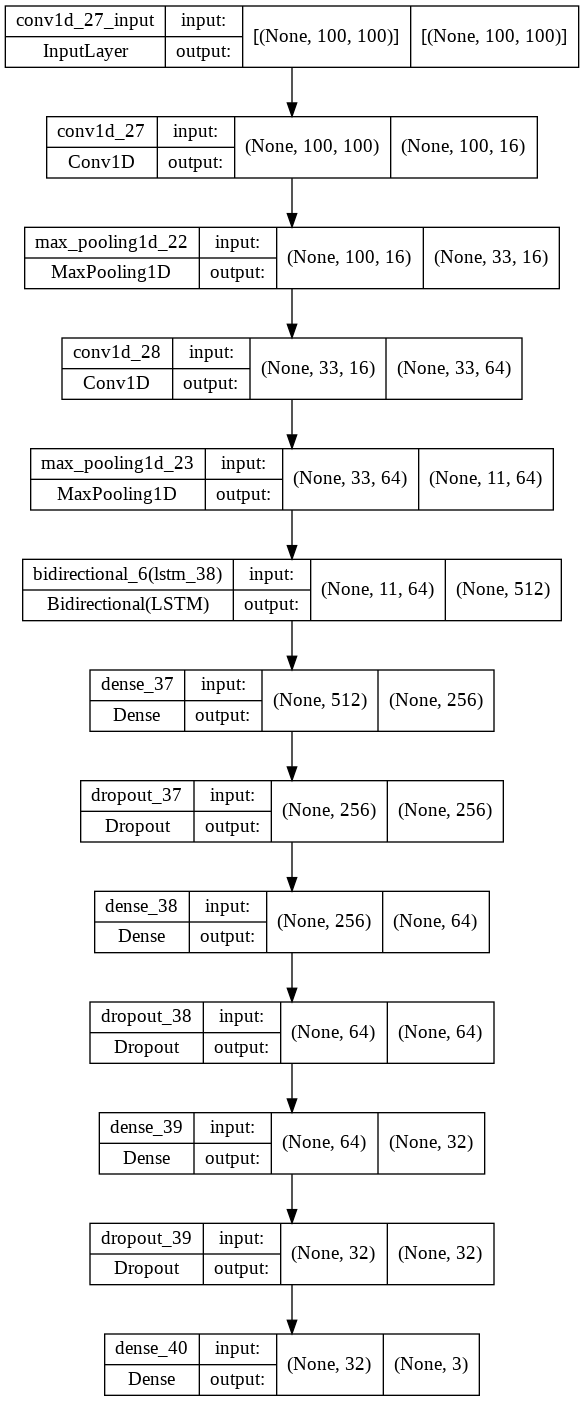

In [148]:
# printing model summary of the saved model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [149]:
# run model evaluations on test data
model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)

36/36 [==============================] - 2s 29ms/step - loss: 1.0633 - accuracy: 0.4665


[1.063301920890808, 0.46649259328842163]

In [162]:
# predict probabilities for test set
yhat_probs = model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes=np.argmax(yhat_probs,axis=1)

In [174]:
# pre processing for inference
clas = []
for i in yhat_classes:
  clas.append(i-1)
clas=np.array(clas)
clas

array([ 0,  0,  1, ...,  0,  0, -1])

In [179]:
# pre processing for inference
y_clas= np.array(df_test['sentiment'])
y_clas

array([ 1,  0,  1, ..., -1, -1, -1])

In [200]:
print('FastText+LSTM:')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_clas, clas)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_clas, clas,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_clas, clas,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_clas, clas,average='weighted')
print('F1 score: %f' % f1)

FastText+LSTM:
Accuracy: 0.466493
Precision: 0.403607
Recall: 0.466493
F1 score: 0.367768


In [204]:
# build a confusion matrix
cm = confusion_matrix(y_clas, clas)
print(cm)

[[ 24 171  24]
 [ 33 486  23]
 [ 33 329  26]]


In [285]:
# reference: https://leslietj.github.io/2020/06/22/Draw-Confusion-Matrix-for-CNN-models/
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')
# 
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    print(len(target_names))
    plt.ylim(len(target_names)-0.5, -0.5)
    # plt.xlim(len(target_names)-0.5, 0)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.grid(None)
    # , bbox_inches = 'tight'
    plt.savefig(title + '.png', dpi=500)
    plt.show()

3


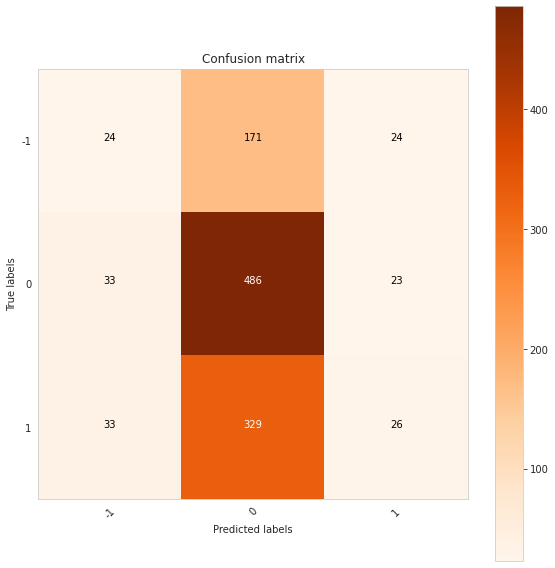

In [286]:
plot_confusion_matrix(cm, ['-1', '0', '1'])